In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from joblib import Parallel,delayed

In [2]:
path = '../data/data_emas_all_duration_day.p'
data1 = pickle.load(open(path,'rb'))

In [61]:
import numpy as np
import pylab as pb
import GPy 
%pylab inline
def get_predictions(X,Y,error):
    X = (X - np.mean(X))/np.std(X)
    mm = np.mean(Y)
    ss = np.std(Y)
    Y = (Y-np.mean(Y))/ss
    kern =  GPy.kern.RBF(input_dim=1)
    Y_meta = {'output_index':np.arange(len(Y))[:,None]}
    m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
    m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    m.optimize()
    preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
    return preds*ss+mm,varss



def get_data(data):
    final_data = []
    df = pd.DataFrame({'duration':data[0],'data':data[1],'ema':data[2],'user':data[3],'hand':data[4]})

    from scipy.stats import iqr
    def get_weighted_rr_features(a):
        f = np.percentile(a[:len(a)//2,0],80)/np.percentile(a[(len(a)//2):,0],80)
        a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
        return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20)])
    
#     def get_feature1(a):
# #         try:
#         a = a[['time','stress_likelihood_ppg_qual','quality_mag']].dropna()
#         if a.shape[0]<5:
#             return np.nan
#         preds = get_predictions(a['time'].values,a['stress_likelihood_ppg_qual'].values,(1-a['quality_mag'].values)/6)
#         a['stress_likelihood_ppg_qual_final'] = preds[0]
#         plt.plot(a['time'],preds[0])
#         plt.show()
#         return a
#         except:
#             return np.nan
    
    def get_feature(a):
        try:
#             print(a.columns)
            a = a[['stress_likelihood_ppg_qual','quality_mag']].dropna().values
            
            return get_weighted_rr_features(a)
        except:
            return np.nan
    
    
    def get_quality(a):
        try:
            a = a['quality_mag'].dropna().values
            return np.percentile(a,80)
        except:
            return np.nan

    for i,data2 in list(df.groupby('user',as_index=False)):
#         print(data2.ema.iloc[0])
#         data2['feature'] = data2['data'].apply(lambda a:get_feature1(a))
#         data2 = data2.dropna()
        data2['feature'] = data2['data'].apply(lambda a:get_feature(a))
        data2['score'] = data2['ema'].apply(lambda a:a['score'])
        data2['label'] = data2['ema'].apply(lambda a:a['label'])
        data2['happy'] = data2['ema'].apply(lambda a:a['all_scores'][0])
        data2['joyful'] = data2['ema'].apply(lambda a:a['all_scores'][1])
        data2['nervous'] = data2['ema'].apply(lambda a:a['all_scores'][2])
        data2['sad'] = data2['ema'].apply(lambda a:a['all_scores'][3])
        data2['angry'] = data2['ema'].apply(lambda a:a['all_scores'][4])
        labels = data2[['happy','joyful','nervous','sad','angry']].values
        for j in range(labels.shape[1]):
            t = labels[:,j]
            t[t<=np.mean(t)] = 0
            t[t!=0] = 1
            labels[:,j] = t
        labels = np.sum(labels,axis=1)
        labels[labels<=2] = 0
        labels[labels!=0] = 1
        data2['label'] = labels
        print(data2['label'].values)
        data2['quality'] = data2['data'].apply(lambda a:get_quality(a))
        data2 = data2[['duration','user','quality','hand','feature','score','label','data']].dropna()
        final_data.append(data2)
    return final_data
        
output = Parallel(n_jobs=30,verbose=3)(delayed(get_data)(data) for data in data1)
# output = [get_data(data) for data in data1]
final_data = []
for r in output:
    final_data.extend(r)
#     print(data['feature'])
# data['ema'].loc[547]

Populating the interactive namespace from numpy and matplotlib


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   3 out of  22 | elapsed:   26.1s remaining:  2.8min
[Parallel(n_jobs=30)]: Done  11 out of  22 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=30)]: Done  19 out of  22 | elapsed:  2.1min remaining:   19.4s
[Parallel(n_jobs=30)]: Done  22 out of  22 | elapsed:  3.0min finished


In [62]:
data = pd.concat(final_data)
def get_labels(df):
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
    if np.sum(df['label'])<3:
        return pd.DataFrame([],columns=df.columns)
    return df
data_global = data.groupby(['user','duration'],as_index=False).apply(get_labels)

In [63]:
names = ['var','iqr','mean','median','80','20']
for i in range(len(names)):
    data[names[i]] = data['feature'].apply(lambda a:a[i])

In [64]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score,roc_auc_score,roc_curve,auc,precision_recall_curve,f1_score,classification_report,confusion_matrix,make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_predict
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

In [65]:
import warnings
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings('ignore')
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def f1Bias_scorer_CV_2(probs, y, ret_bias=False):
    fpr, tpr, thresholds = roc_curve(y, probs)
    f1 = 0.0
    bias = 0
    for i in range(0, len(thresholds)):
        temp_y_pred = deepcopy(y)
        temp_y_pred[temp_y_pred>thresholds[i]] = 1
        temp_y_pred[temp_y_pred<=thresholds[i]] = 0
        f = f1_score(y,np.int32(temp_y_pred))
        if f > f1:
            f1 = f
            bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_classification_report(X,y,n):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
            'rf__C': np.logspace(-3,3,10),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'rf__solver': ['lbfgs'],
            'pca__n_components':[1,2,3,4,5]
        }
    clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring=my_score,verbose=1, return_train_score=False)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    roc = roc_auc_score(y,probs)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return a,roc,pearsonr(y,y_pred)[0],confusion_matrix(y,y_pred) 

# def get_classification_report(X,y,n):
#     my_score = make_scorer(my_score_auc,needs_threshold=True)
#     paramGrid = ParameterGrid({
#             'rf__C': np.logspace(-3,3,10),
#             'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
#             'rf__solver': ['lbfgs'],
#             'pca__n_components':[1,2,3,4,5]
#         })
#     clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
#     all_f1,all_auc,all_corr = [],[],[]
#     for params in paramGrid:
#         f1 = []
#         auc = []
#         pearsonrr = []
#         clf.set_params(**params)
#         for train_index,test_index in StratifiedKFold(n_splits=n).split(X, y):
#             X_train,X_test = X[train_index],X[test_index]
#             y_train,y_test = y[train_index],y[test_index]
#             clf.fit(X_train,y_train)
#             y_pred = clf.predict_proba(X_test)[:,1]
#             f1.append(f1_score(y_test,clf.predict(X_test)))
#             auc.append(my_score_auc(y_test,y_pred))
#             pearsonrr.append(pearsonr(y_test,y_pred)[0])
#         all_f1.append(np.mean(f1))
#         all_auc.append(np.mean(auc))
#         all_corr.append(np.mean(pearsonrr))
#     ind_max = np.argmax(all_auc)
#     return all_f1[ind_max],all_auc[ind_max],all_corr[ind_max]

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)
def get_data_again(df):
    data_all = []
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return []
    if df.label.sum()<3:
        return []
    if len(np.unique(df['label'].values))<2:
        return []
    user = df['user'].values[0]
    print(df.shape,df.columns,df['label'].unique())
    X = np.array(list(df['feature']))
    y = np.int64(np.array(list(df['label'])))
    n = 3
    try:
        f1_all,auc_all,p_all,conf_matrix = get_classification_report(X,np.int64(y),n)
    except:
        return []
    for k,name in enumerate(names):
        data_all.append([user,name,df['duration'].values[0],
                         my_score_auc(df['label'].values,df[name].values),
                         f1Bias_scorer_CV(df[name].values,df['label'].values),
                         pearsonr(df[name].values,df['score'].values)[0]])
    data_all.append([user,'Logistic Regression',df['duration'].values[0],
                         auc_all,
                         f1_all,
                         p_all])
    return data_all
output = Parallel(n_jobs=-1,verbose=3)(delayed(get_data_again)(df) for i,df in list(data.groupby(['duration','user'],as_index=False)))
# output = [get_data_again(df) for i,df in list(data.groupby(['duration','user'],as_index=False))]
data_all = []
for r in output:
    data_all.extend(r)
#         print(r,pearsonr(df['80th'].values,df['score'].values),df['duration'].values[0],df['user'].values[0],df.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1659 out of 1659 | elapsed:  2.0min finished


In [66]:
import seaborn as sns
df = pd.DataFrame(data_all,columns=['user','feature','window_size','auc','f1','corr'])

In [67]:
df['user'].unique().shape
df1 = df.groupby(['feature','window_size'],as_index=False).median()

In [68]:
def get_max_auc(df):
    df = df.sort_values('auc').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df

some_data = df1.groupby('feature',as_index=False).apply(get_max_auc)

In [69]:
tt = df1.groupby(['feature','window_size'],as_index=False).max().sort_values('auc').reset_index(drop=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

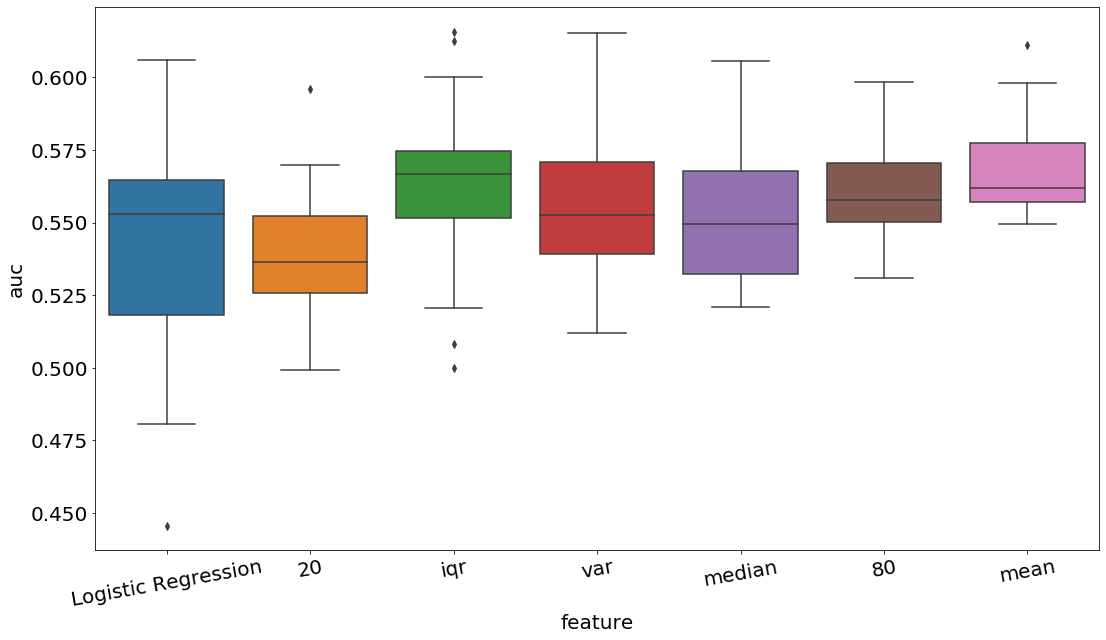

In [70]:
plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size':20})
sns.boxplot(x='feature',y='auc',data=tt)
plt.xticks(rotation=10)

In [55]:
tt1 = tt[tt.feature=='Logistic Regression'].sort_values('auc').reset_index(drop=True)
tt1

,feature,window_size,auc,f1,corr
0,Logistic Regression,5,0.494898,0.669967,0.401766
1,Logistic Regression,65,0.515625,0.647059,0.295116
2,Logistic Regression,15,0.521429,0.695652,0.367846
3,Logistic Regression,25,0.527778,0.681818,0.382021
4,Logistic Regression,55,0.528646,0.652731,0.333333
5,Logistic Regression,165,0.529911,0.680567,0.350588
6,Logistic Regression,95,0.535119,0.638182,0.271163
7,Logistic Regression,75,0.540000,0.645161,0.309719
8,Logistic Regression,85,0.540588,0.639393,0.333333
9,Logistic Regression,45,0.542857,0.666667,0.287505


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

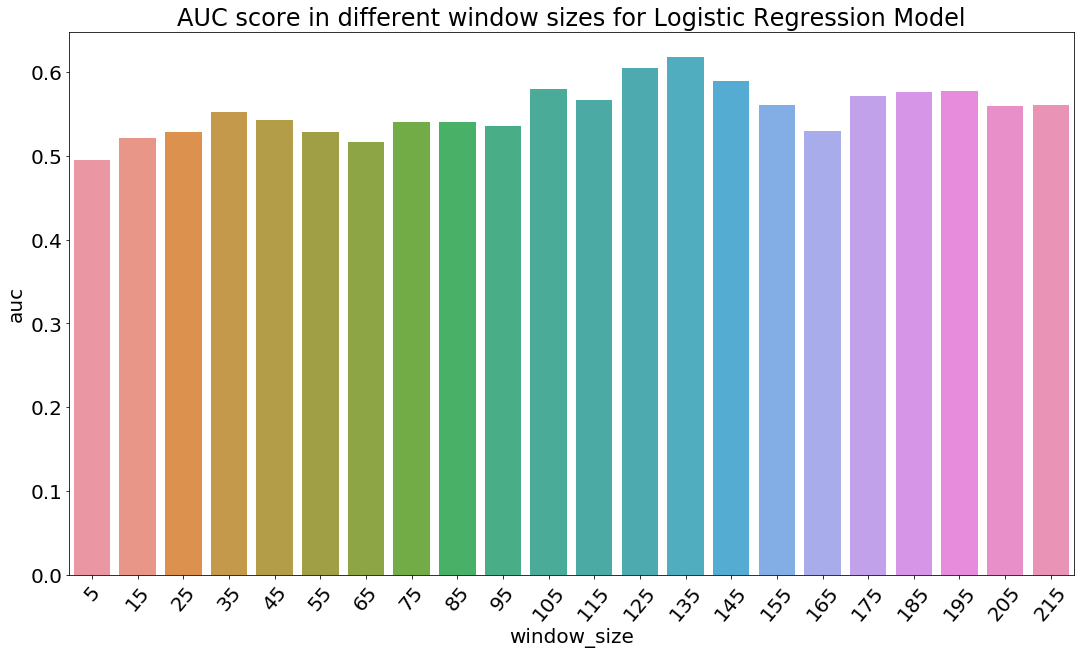

In [56]:
plt.figure(figsize=(18,10))
sns.barplot(x='window_size',y='auc',data=tt1)
plt.title('AUC score in different window sizes for Logistic Regression Model')
plt.xticks(rotation=50)

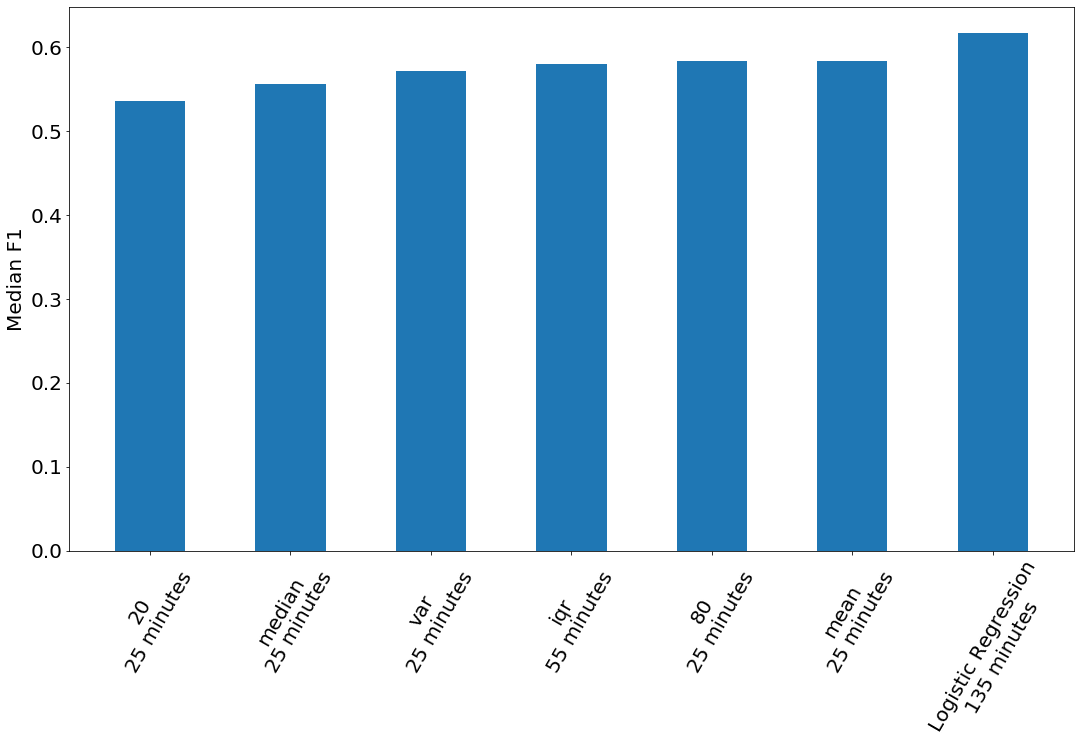

In [57]:
some_data = some_data.sort_values('auc').reset_index(drop=True)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,10))
plt.bar(some_data['feature'],some_data['auc'],.5)
plt.ylabel('Median F1')
plt.xticks(range(some_data.shape[0]),[row['feature']+'\n'+str(row['window_size'])+' minutes' for i,row in some_data.iterrows()],rotation=60)
plt.show()

(0.6169369845840434, 0.6749999999999999, (46, 7))

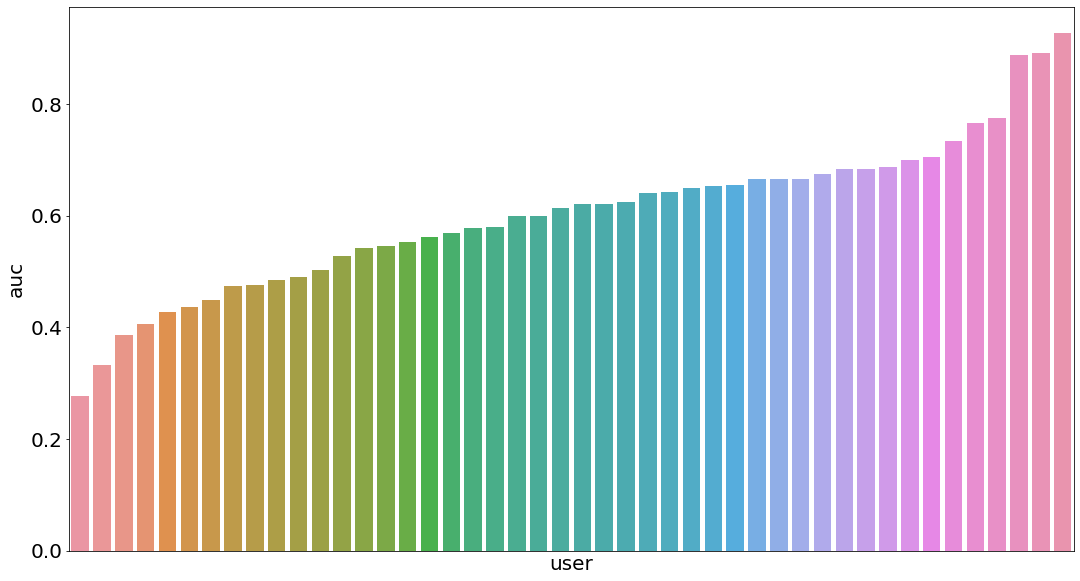

In [58]:
plt.figure(figsize=(18,10))
df2 =  df[(df.feature=='Logistic Regression')&(df.window_size==135)].sort_values('auc')
df2['user1'] = range(df2.shape[0])
sns.barplot(x='user',y='auc',data=df2)
plt.xticks([])
df2['auc'].median(),df2['f1'].median(),df2.shape
# plt.legend(ncol=10)

In [59]:
df1[df1.feature=='Logistic Regression'].sort_values('auc')

,feature,window_size,auc,f1,corr
44,Logistic Regression,5,0.494898,0.669967,0.401766
50,Logistic Regression,65,0.515625,0.647059,0.295116
45,Logistic Regression,15,0.521429,0.695652,0.367846
46,Logistic Regression,25,0.527778,0.681818,0.382021
49,Logistic Regression,55,0.528646,0.652731,0.333333
60,Logistic Regression,165,0.529911,0.680567,0.350588
53,Logistic Regression,95,0.535119,0.638182,0.271163
51,Logistic Regression,75,0.540000,0.645161,0.309719
52,Logistic Regression,85,0.540588,0.639393,0.333333
48,Logistic Regression,45,0.542857,0.666667,0.287505


(-0.5, 1)

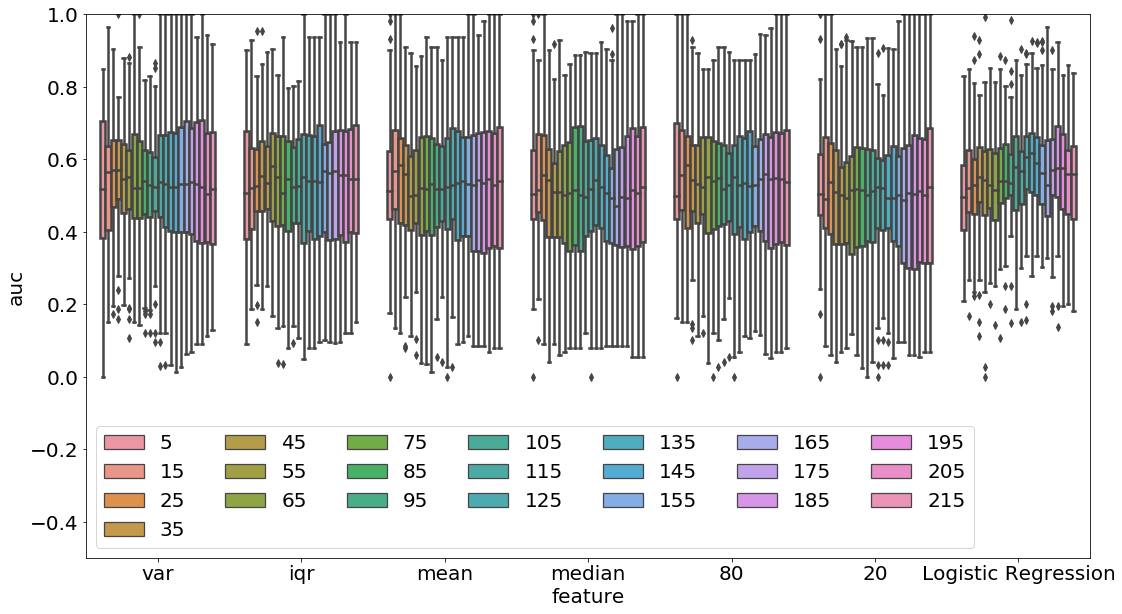

In [60]:
import matplotlib.pyplot as plt
# df = df[df['window size']<20]
plt.figure(figsize=(18,10))
sns.boxplot(x="feature", y='auc', hue="window_size",
                 data=df, linewidth=2.5)
plt.legend(ncol=7)
plt.ylim([-.5,1])
# plt.hlines(.5,1,7)

(-0.5, 1)

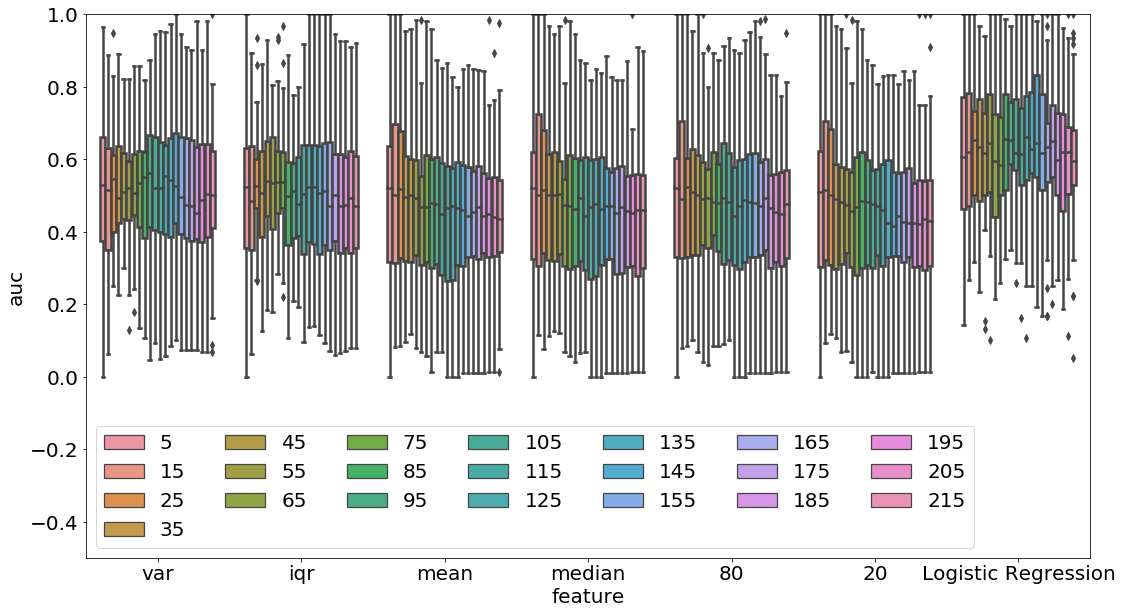

In [20]:
sns.barplot(df[])

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

In [ ]:
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and precision[i]>recall[i]-.1:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)    

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [10,1,100,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[True]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b,'rr')
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred),confusion_matrix(y,y_pred))
#     clf.fit(X,y)
    return np.array([f1_score(y,y_pred),roc_auc_score(y,y_pred),recall_score(y,y_pred)])

In [ ]:
def get_user_results(df):
    print(df['duration'].unique())
    qual = df['q'].values[0]
    groups = np.array(list(df['user']))
    X = np.array(list(df['feature']))
    y = np.array(list(df['label']))
    duration = df['duration'].values[0]
    print(duration,qual)
    arr = get_results(X,y,groups)
    return pd.DataFrame([[duration,qual,arr[0],arr[1],arr[2]]],columns=['duration','quality','f1','precision','recall'])

In [ ]:
import numpy as np
def get_results_qual(data_global,q):
    data_global1 = deepcopy(data_global[data_global.quality>=q]).reset_index(drop=True)
    print(data_global1['duration'].unique())
    print(data_global1.shape,data_global.shape)
    data_global1['q'] = q
    data_d = data_global1.groupby('duration',as_index=False).apply(get_user_results)
    return data_d
from joblib import Parallel,delayed
# all_data = Parallel(n_jobs=-1,verbose=3)(delayed(get_results_qual)(data_global,q) for q in np.arange(0,.5,.05))
all_data = [get_results_qual(data_global,q) for q in np.arange(0,.5,.05)]

In [ ]:
results = pd.concat(all_data)

In [ ]:
results.groupby('quality').max()